In [1]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score, recall_score, f1_score, auc
from sklearn.model_selection import train_test_split
from keras import layers, Model
from keras.models import Sequential, load_model
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras import regularizers, layers, losses
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, PrecisionRecallDisplay
from keras.utils import plot_model
import pandas as pd
import seaborn as sns
import joblib
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

(39000, 14)
(40000, 14)


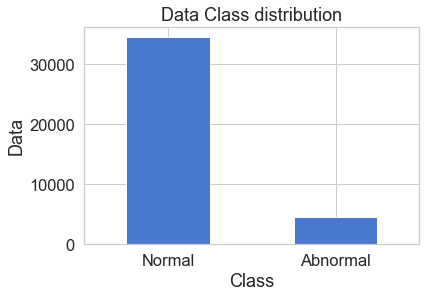

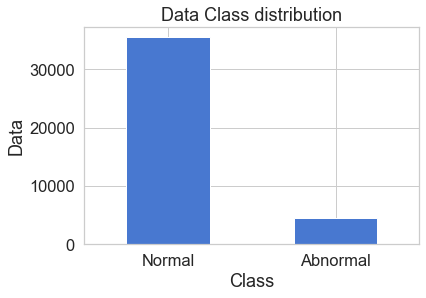

In [2]:
# Generate some sample data for the autoencoder
# x_train = np.random.rand(1000, 12)
# x_test = np.random.rand(100, 12)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

RANDOM_SEED = 42

df = pd.read_csv("Autoencoder1.csv")  
print(df.shape)

df2 = pd.read_csv("Autoencoder_wind.csv")
print(df2.shape)

LABELS = ["Normal", "Abnormal"]

count_classes =pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Data Class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Data")
plt.show();

count_classes2 =pd.value_counts(df2['Class'], sort = True)
count_classes2.plot(kind = 'bar', rot=0)
plt.title("Data Class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Data")
plt.show();

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from cmath import pi

data = df.drop(['Time'], axis=1)
# y_true = df['Class']

r2d = 180/pi

data['P'] = r2d * data['P']
data['Q'] = r2d * data['Q']
data['R'] = r2d * data['R']
data['Phi'] = r2d * data['Phi']
data['Theta'] = r2d * data['Theta']
data['Psi'] = r2d * data['Psi']

data2 = df2.drop(['Time'], axis=1)
# y_true2 = df2['Class']

r2d = 180/pi

data2['P'] = r2d * data2['P']
data2['Q'] = r2d * data2['Q']
data2['R'] = r2d * data2['R']
data2['Phi'] = r2d * data2['Phi']
data2['Theta'] = r2d * data2['Theta']
data2['Psi'] = r2d * data2['Psi']

In [59]:
X_train, X_test = train_test_split(data2, test_size=0.5, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
y_train = X_train['Class']
X_train = pd.DataFrame(X_train)
X_train = X_train.drop(['Class'], axis=1)

# X_test = X_test[X_test.Class == 0]
y_test = X_test['Class']
X_test = pd.DataFrame(X_test)
X_test = X_test.drop(['Class'], axis=1)

def MinmaxNorm(data1, data2, label):
    for i in label:
        a = data1[i]
        b = data2[i]
        x_max = max(a)
        x_min = min(a)
        for j in list(range(a.shape[0])):
            a.iloc[j] = (a.iloc[j] - x_min) / (x_max - x_min)
        for k in list(range(b.shape[0])):
            b.iloc[k] = (b.iloc[k] - x_min) / (x_max - x_min)
    
    return data1, data2

A = ['RPM1', 'RPM2', 'RPM3', 'RPM4', 'RPM5', 'RPM6', 'P', 'Q', 'R', 'Phi', 'Theta', 'Psi']

X_train, X_test = MinmaxNorm(X_train, X_test, A)

X_train = X_train.values
X_test = X_test.values

In [60]:
def calculate_result(AE_model):
    k = load_model(AE_model)
    pred1 = k.predict(X_train)
    pred2 = k.predict(X_test)
    mse = np.mean(np.power((X_train - pred1), 2), axis=1)
    mse2 = np.mean(np.power((X_test - pred2), 2), axis=1)
    rmse1 = np.sqrt(mse)
    rmse2 = np.sqrt(mse2)
    thresholds = max(rmse1)
    error_df = pd.DataFrame({'reconstruction_error': rmse2,
                            'true_class': y_test})

    error_df.reconstruction_error = error_df.reconstruction_error >= thresholds
    error_df['reconstruction_error'] = error_df['reconstruction_error'].astype(int)

    y_pred = error_df.reconstruction_error
    precision, recall, thresholds1 = precision_recall_curve(y_test, y_pred)
    fpr, tpr, thresholds2 = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    dic1 = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}
    dic2 = {'precision': precision, 'recall': recall, 'f1': f1, 'conf_matix': conf_matrix}
    df = [dic1, dic2]
    
    return df

def calculate_result2(AE_model, GMM_model, rate):
    dic = {}
    k = load_model(AE_model)
    encoded_test_data = k.encoder(X_test).numpy()
    l = joblib.load(GMM_model)
    scores=l.score_samples(encoded_test_data)

    for n in rate:
        threshold = np.percentile(scores, n)
        y_pred = np.zeros_like(scores)
        y_pred[scores < threshold] = 1
        precision, recall, thresholds1 = precision_recall_curve(y_test, y_pred)
        fpr, tpr, thresholds2 = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        f1 = f1_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        dic1 = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}
        dic2 = {'precision': precision, 'recall': recall, 'f1': f1, 'conf_matix': conf_matrix}
        dic[n] = [dic1, dic2]

    df = [dic]
        
    return df

In [69]:
def results_plot(AE_model, Model_Names):
    fig, ax = plt.subplots(figsize=[10, 10])
    sns.set_palette("bright")
    for i in Model_Names:
        ax.plot(AE_model[i][1]['precision'], AE_model[i][1]['recall'], label='F1 score= %0.4f'% AE_model[i][1]['f1'])
    ax.set_xlabel("Precision")
    ax.set_xlabel("Recall")
    ax.set_title("Precision-Recall curve")
    ax.legend(loc='lower left', prop={'size': 15})
    axins = ax.inset_axes([0.3, 0.2, 0.45, 0.45])

    for i in Model_Names:
        axins.plot(AE_model[i][1]['precision'], AE_model[i][1]['recall'])
    
    x1, x2, y1, y2 = 0.95, 1.01, 0.95, 1.01
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    for axis in ['top', 'bottom', 'left', 'right']:
        axins.spines[axis].set_linewidth(3)
        axins.spines[axis].set_color('k')

    axins.set_xticks([])
    axins.set_yticks([])
    axins.grid()

    # indicator = ax.indicate_inset_zoom(axins, edgecolor="black", linewidth = 3)
    indicator = ax.indicate_inset_zoom(axins)
    indicator[0].set_linewidth(3)
    indicator[0].set_edgecolor('k')
    # indicator[0].set_color('k')

    indicator[1][0].set_linewidth(3)
    indicator[1][1].set_linewidth(3)
    indicator[1][2].set_linewidth(3)
    indicator[1][3].set_linewidth(3)

    indicator[1][1].set_color('k')
    indicator[1][2].set_color('k')

def results_plot2(GMM_model, Model_Names, rate):
    fig, ax = plt.subplots(figsize=[10, 10])
    sns.set_palette("bright")
    for i in Model_Names:
        ax.plot(GMM_model[i][0][rate[0]][1]['precision'], GMM_model[i][0][rate[0]][1]['recall'], label='F1 score= %0.4f'% GMM_model[i][0][rate[0]][1]['f1'])
    ax.set_xlabel("Precision")
    ax.set_xlabel("Recall")
    ax.set_title("Precision-Recall curve")
    ax.legend(loc='lower left', prop={'size': 15})
    axins = ax.inset_axes([0.3, 0.2, 0.45, 0.45])

    for i in Model_Names:
        axins.plot(GMM_model[i][0][rate[0]][1]['precision'], GMM_model[i][0][rate[0]][1]['recall'])
    
    x1, x2, y1, y2 = 0.95, 1.01, 0.95, 1.01
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    for axis in ['top', 'bottom', 'left', 'right']:
        axins.spines[axis].set_linewidth(3)
        axins.spines[axis].set_color('k')

    axins.set_xticks([])
    axins.set_yticks([])
    axins.grid()

    # indicator = ax.indicate_inset_zoom(axins, edgecolor="black", linewidth = 3)
    indicator = ax.indicate_inset_zoom(axins)
    indicator[0].set_linewidth(3)
    indicator[0].set_edgecolor('k')
    # indicator[0].set_color('k')

    indicator[1][0].set_linewidth(3)
    indicator[1][1].set_linewidth(3)
    indicator[1][2].set_linewidth(3)
    indicator[1][3].set_linewidth(3)

    indicator[1][1].set_color('k')
    indicator[1][2].set_color('k')

def results_plot3(AE_model, GMM_model,  Model_Names1, Model_Names2, rate):
    fig, ax = plt.subplots(figsize=[10, 10])
    sns.set_palette("bright")
    for i in Model_Names1:
        ax.plot(AE_model[i][1]['precision'], AE_model[i][1]['recall'], label='{} = %0.4f'.format(i) % AE_model[i][1]['f1'])
    for i in Model_Names2:
        ax.plot(GMM_model[i][0][rate[0]][1]['precision'], GMM_model[i][0][rate[0]][1]['recall'], label='{} = %0.4f'.format(i) % GMM_model[i][0][rate[0]][1]['f1'])
    ax.set_xlabel("Precision")
    ax.set_xlabel("Recall")
    ax.set_title("Precision-Recall curve")
    ax.legend(loc='lower left', prop={'size': 15})
    axins = ax.inset_axes([0.3, 0.2, 0.45, 0.45])
    
    for i in Model_Names1:
        axins.plot(AE_model[i][1]['precision'], AE_model[i][1]['recall'])
    for i in Model_Names2:
        axins.plot(GMM_model[i][0][rate[0]][1]['precision'], GMM_model[i][0][rate[0]][1]['recall'])
    
    x1, x2, y1, y2 = 0.95, 1.01, 0.95, 1.01
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    for axis in ['top', 'bottom', 'left', 'right']:
        axins.spines[axis].set_linewidth(3)
        axins.spines[axis].set_color('k')

    axins.set_xticks([])
    axins.set_yticks([])
    axins.grid()

    # indicator = ax.indicate_inset_zoom(axins, edgecolor="black", linewidth = 3)
    indicator = ax.indicate_inset_zoom(axins)
    indicator[0].set_linewidth(3)
    indicator[0].set_edgecolor('k')
    # indicator[0].set_color('k')

    indicator[1][0].set_linewidth(3)
    indicator[1][1].set_linewidth(3)
    indicator[1][2].set_linewidth(3)
    indicator[1][3].set_linewidth(3)

    indicator[1][1].set_color('k')
    indicator[1][2].set_color('k')


625/625 [==============================] - 0s 749us/step


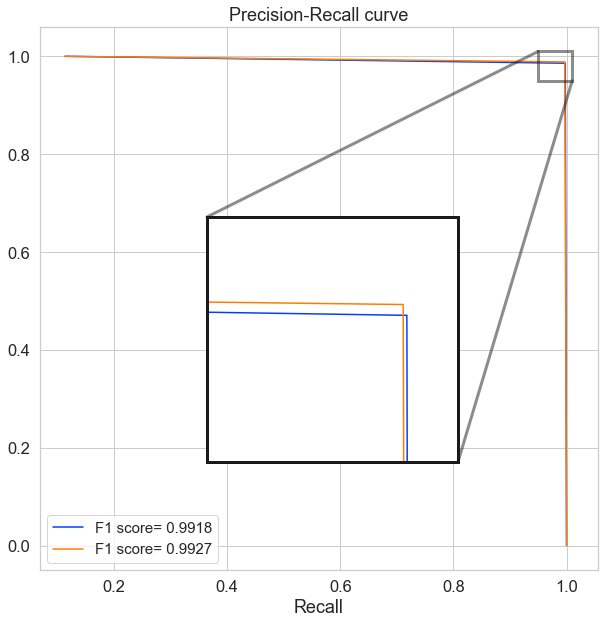

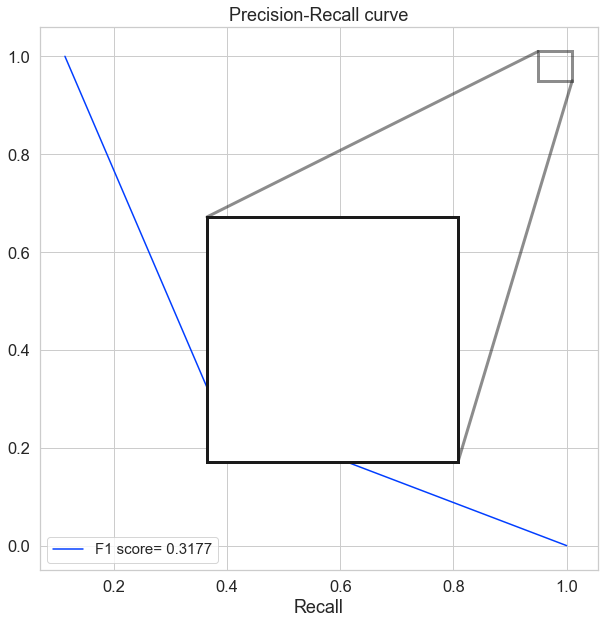

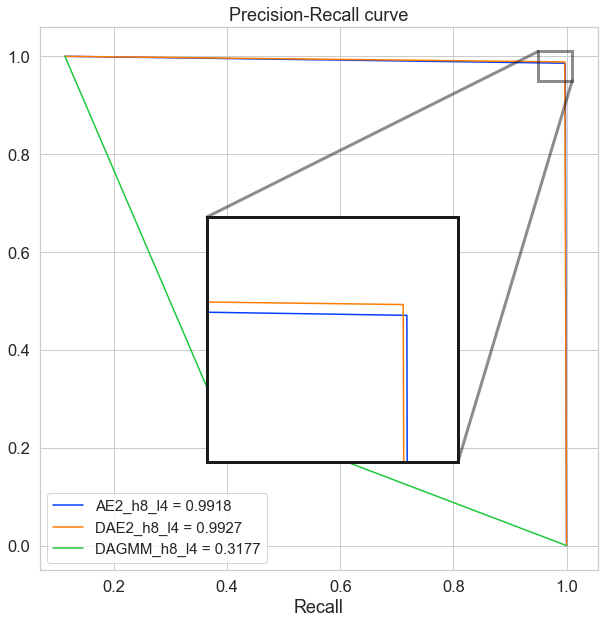

In [73]:
# Autoencoder
Model_Names1 = ["AE2_h8_l4", "DAE2_h8_l4"]
AE_models = ["AE2_h8_l4", "DAE2_h8_l4"]
AE_model = {}
for key in list(AE_model.keys()):
    name = Model_Names1
    AE_model[name] = AE_model.pop(key)

for i in AE_models:
    AE_model[i] = calculate_result(i)

results_plot(AE_model, Model_Names1)
plt.show();

# print(AE_model)
# print(AE_model[Model_Names[0]][0]['fpr'])
# Model_Names의 첫번째 모델의 데이터 : AE_model[Model_Names[0]] 

# DAGMM
rate = list(np.arange(8,11,0.2))
Model_Names2 = ["DAGMM_h8_l4"]
DA_models = ["DAGMM_AE_h8_l4"]
GMM_models = ["DAGMM_GMM_h8_l4_n1.pkl"]
GMM_model = {}
for key in list(GMM_model.keys()):
    name = Model_Names2
    GMM_model[name] = GMM_model.pop(key)
k = 0
for i in Model_Names2:
    GMM_model[i] = calculate_result2(DA_models[k], GMM_models[k], rate)
    k+=1

results_plot2(GMM_model, Model_Names2, rate)
plt.show();

# print(GMM_model)
# print(GMM_model[Model_Names[0]][0][rate[0]][0]['fpr'])
# Model_Names의 첫번째 모델의 데이터 : GMM_model[Model_Names[0]]

results_plot3(AE_model, GMM_model, Model_Names1, Model_Names2, rate)
plt.show();